In [2]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# IBMQ.load_account()
# provider = IBMQ.get_provider(
# 	hub='partner-cnr',
# 	group='icar-napoli',
# 	project='gargiulo'
# )


In [3]:
# declare quantum instance
#qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
real_device = Aer.get_backend("aer_simulator_statevector")
#real_device=provider.get_backend("ibmq_bogota")
qi = QuantumInstance(real_device)
properties = real_device.properties()
coupling_map = real_device.configuration().coupling_map

In [4]:
# se non sono sulla macchina quantum reale dovrebbe restituire None per entrambi
print(properties)
print(coupling_map)

None
None


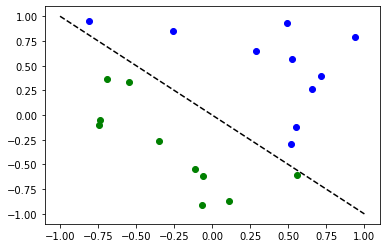

In [5]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for CircuitQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for OplowQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [6]:
# Set up QNN
# Note: we are not providing them explicitly in this examples,
# but TwoLayerQNN requires a feature_map and ansatz to work.
# By default, these parameters are set to  ZZFeatureMap
# and RealAmplitudes (respectively).
qnn1 = TwoLayerQNN(num_qubits=num_inputs, quantum_instance=qi)
print(qnn1.operator)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐»
  q_0: ┤0                         ├»
       │  ZZFeatureMap(x[0],x[1]) │»
  q_1: ┤1                         ├»
       └──────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────┐
  «q_0: ┤0                                                         ├
  «     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
  «q_1: ┤1                                                         ├
  «     └──────────────────────────────────────────────────────────┘
  )
])
Initial weights:  [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


In [7]:
print('X.shape: ' + str(X.shape))
print('y.shape: ' + str(y.shape))
print('type(X): ' + str(type(X)))
print('type(y): ' + str(type(y)))
print('X[:7, :]:' + str(X[:7, :]))
print('y[:7]:' + str(y[:7]))

X.shape: (20, 2)
y.shape: (20,)
type(X): <class 'numpy.ndarray'>
type(y): <class 'numpy.ndarray'>
X[:7, :]:[[ 0.5479121  -0.12224312]
 [ 0.71719584  0.39473606]
 [-0.8116453   0.9512447 ]
 [ 0.5222794   0.57212861]
 [-0.74377273 -0.09922812]
 [-0.25840395  0.85352998]
 [ 0.28773024  0.64552323]]
y[:7]:[ 1  1  1  1 -1  1  1]


In [8]:
# model1 non è addestrato, ha dei pesi causali che sono quelli di sopra
# la decision function è: se il segno dell'output è negativo la classe è -1, viceversa è 1

y_predict = []
for x, y_target in zip(X, y):
    print('x:' + str(x))
    print('y_target:' + str(y_target))
    output = model1(Tensor(x))
    print('output:' + str(output))
    y_predict += [np.sign(output.detach().numpy())[0]]
    print('y_predict:' + str(y_predict))
    
print("Accuracy:", sum(y_predict == y) / len(y))

x:[ 0.5479121  -0.12224312]
y_target:1
output:tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0]
x:[0.71719584 0.39473606]
y_target:1
output:tensor([0.4164], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0]
x:[-0.8116453  0.9512447]
y_target:1
output:tensor([0.1083], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0, 1.0]
x:[0.5222794  0.57212861]
y_target:1
output:tensor([0.1538], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0, 1.0, 1.0]
x:[-0.74377273 -0.09922812]
y_target:-1
output:tensor([0.9667], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0, 1.0, 1.0, 1.0]
x:[-0.25840395  0.85352998]
y_target:1
output:tensor([-0.0525], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0, 1.0, 1.0, 1.0, -1.0]
x:[0.28773024 0.64552323]
y_target:1
output:tensor([-0.1425], grad_fn=<_TorchNNFunctionBackward>)
y_predict:[-1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0]
x:[-0.1131716  -0.54552256]
y_target:-1
output:tensor([0.1356], grad_fn=<_TorchNNFun

In [9]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")
# print('optimizer: ' + str(optimizer))
# print('f_loss: ' + str(f_loss))
# Start training
model1.train()  # set model to training mode
# print('model1.train(): ' + str(model1.train()))

# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.

# la loss è contenuta in un tensore
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    print('X_: ' + str(X_[:4, :]))
    print('y_: ' + str(y_[:4]))
    loss.backward()  # Backward pass
    print('loss.item(): ' + str(loss.item()))  # Print loss
    print('loss: ' + str(loss)) 
    return loss

# Run optimizer step4
optimizer.step(closure)

X_: tensor([[ 0.5479, -0.1222],
        [ 0.7172,  0.3947],
        [-0.8116,  0.9512],
        [ 0.5223,  0.5721]])
y_: tensor([[1.],
        [1.],
        [1.],
        [1.]])
loss.item(): 25.535646438598633
loss: tensor(25.5356, grad_fn=<MseLossBackward0>)
X_: tensor([[ 0.5479, -0.1222],
        [ 0.7172,  0.3947],
        [-0.8116,  0.9512],
        [ 0.5223,  0.5721]])
y_: tensor([[1.],
        [1.],
        [1.],
        [1.]])
loss.item(): 22.696760177612305
loss: tensor(22.6968, grad_fn=<MseLossBackward0>)
X_: tensor([[ 0.5479, -0.1222],
        [ 0.7172,  0.3947],
        [-0.8116,  0.9512],
        [ 0.5223,  0.5721]])
y_: tensor([[1.],
        [1.],
        [1.],
        [1.]])
loss.item(): 20.039230346679688
loss: tensor(20.0392, grad_fn=<MseLossBackward0>)
X_: tensor([[ 0.5479, -0.1222],
        [ 0.7172,  0.3947],
        [-0.8116,  0.9512],
        [ 0.5223,  0.5721]])
y_: tensor([[1.],
        [1.],
        [1.],
        [1.]])
loss.item(): 19.687908172607422
loss: tens

tensor(25.5356, grad_fn=<MseLossBackward0>)

In [10]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    print('x, y_target: ' + str(x) + ', ' + str(y_target))
    output = model1(Tensor(x))
    print('output: ' + str(output))
    y_predict += [np.sign(output.detach().numpy())[0]]
    print('y_predict: ' + str(y_predict))

print("Accuracy:", sum(y_predict == y) / len(y))

x, y_target: [ 0.5479121  -0.12224312], 1
output: tensor([0.0754], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0]
x, y_target: [0.71719584 0.39473606], 1
output: tensor([0.0713], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0]
x, y_target: [-0.8116453  0.9512447], 1
output: tensor([0.2625], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0, 1.0]
x, y_target: [0.5222794  0.57212861], 1
output: tensor([0.1930], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0, 1.0, 1.0]
x, y_target: [-0.74377273 -0.09922812], -1
output: tensor([-0.1945], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0, 1.0, 1.0, -1.0]
x, y_target: [-0.25840395  0.85352998], 1
output: tensor([0.5925], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0, 1.0, 1.0, -1.0, 1.0]
x, y_target: [0.28773024 0.64552323], 1
output: tensor([0.2676], grad_fn=<_TorchNNFunctionBackward>)
y_predict: [1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0]
x, y_target: [-0.1131716  -0.54552256], -1
output: tensor(

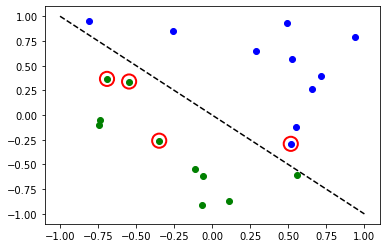

In [11]:
# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [12]:
from qiskit import IBMQ, Aer
provider = IBMQ.load_account()
available_cloud_backends = provider.backends() 
print('\nHere is the list of cloud backends that are available to you:')
for i in available_cloud_backends: print(i)

ibmqfactory.load_account:WARNING:2022-05-24 09:41:01,081: Credentials are already in use. The existing account in the session will be replaced.



Here is the list of cloud backends that are available to you:
ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila
